Import Library

In [58]:
!pip install wandb

In [59]:
from keras.datasets import fashion_mnist, mnist
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import wandb

**Plotting various Categories of data**

In [60]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [61]:
# MetaData of Fashion_Mnist dataset ...
CLASSES = {
  0:'T-shirt/top',
  1:'Trouser',
  2:'Pullover',
  3:'Dress',
  4:'Coat',
  5:'Sandal',
  6:'Shirt',
  7:'Sneaker',
  8:'Bag',
  9:'Ankle boot'
}

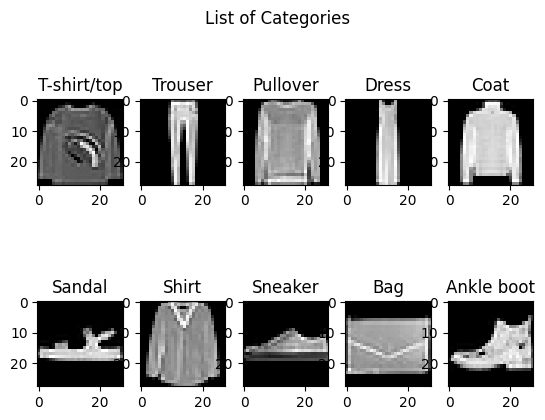

In [62]:
ind_of_first_occurance = np.argsort(y_train)
ind = ind_of_first_occurance[np.searchsorted(y_train, np.arange(0,10,1), sorter=ind_of_first_occurance)]
fig, ax = plt.subplots(nrows=2, ncols=5)
for i in range(10):
  ax[i//5, i%5].imshow(x_train[ind[i]], cmap='gray')
  ax[i//5, i%5].set_title(CLASSES[i])

fig.suptitle('List of Categories')
plt.show()

In [63]:
def load_data(dataset='fashion_mnist', purpose='train'):
  dataset=dataset.lower()
  purpose=purpose.lower()
  x,x_t,y,y_t = None,None,None,None

  if dataset == 'fashion_mnist':
    (x, y), (x_t, y_t) = fashion_mnist.load_data()
  elif dataset == 'mnist':
    (x, y), (x_t, y_t) = mnist.load_data()

  if purpose == 'train':
    x = x.reshape(x.shape[0], 784) / 255
    y = np.eye(10)[y]
    return x, y
  elif purpose == 'test':
    x_t = x_t.reshape(x_t.shape[0], 784) / 255
    y_t = np.eye(10)[y_t]
    return x_t, y_t

**Feed Forward Neural Net**

In [64]:
class FF_NN:

  def __init__(self, param):
    self.hidden_layers = param['hidden_lyrs']
    self.neurons = param['neurons']
    self.input_neurons = param['inpt_sz'] # self.x_train.shape[1] * self.x_train.shape[2]
    self.output_neurons = param['oupt_sz'] # len(CLASSES)
    self.weights = []
    self.bias = []
    self.activation = param['activation']
    self.output_activation = param['oupt_activation']
    self.weight_initialisation = param['weight_initialisation']

    self.get_weights()
    self.get_bias()


  def get_bias(self):
    for _ in range(self.hidden_layers):
      self.bias.append(np.random.randn(self.neurons))
    self.bias.append(np.random.randn(self.output_neurons))

  def get_weights(self):
    if self.weight_initialisation.lower() == 'random':
      self.weights.append(np.random.randn(self.input_neurons, self.neurons))
      for _ in range(self.hidden_layers-1):
        self.weights.append(np.random.randn(self.neurons, self.neurons))
      self.weights.append(np.random.randn(self.neurons, self.output_neurons))

    else:
      limit = np.sqrt(6/(self.input_neurons + self.neurons))
      self.weights.append(np.random.uniform(low=-limit, high=limit, size=(self.input_neurons, self.neurons)))
      limit = np.sqrt(6/(self.neurons + self.neurons))
      for _ in range(self.hidden_layers-1):
        self.weights.append(np.random.uniform(low=-limit, high=limit, size=(self.neurons, self.neurons)))
      limit = np.sqrt(6/(self.neurons + self.output_neurons))
      self.weights.append(np.random.uniform(low=-limit, high=limit, size=(self.neurons, self.output_neurons)))


  def apply_activation(self, data):
    act = self.activation.lower()
    if act == 'sigmoid':
      return 1/(1+np.exp(-data))
    elif act == 'relu':
      return np.maximum(0,data)
    elif act == 'tanh':
      return np.tanh(data)
    elif act == 'identity':
      return data


  def apply_output_activation(self, data):
    if self.output_activation.lower() == 'softmax':
      data = np.exp(data)
      return data/np.sum(data,axis=1).reshape(data.shape[0],1)


  def feed_forward(self, input):
    self.A = [input]
    self.H = [input]

    # hidden layer calculations...
    for i in range(self.hidden_layers):
      self.A.append(self.bias[i] + np.matmul(self.H[-1], self.weights[i]))
      self.H.append(self.apply_activation(self.A[-1]))

    # output layer calculations...
    self.A.append(self.bias[-1] + np.matmul(self.H[-1], self.weights[-1]))
    self.H.append(self.apply_output_activation(self.A[-1]))

    return self.H[-1] # shape of H[-1] = 60000,10   shape of H = layers, 60000, neurons in each layer


In [65]:
# nn = FF_NN(PARAMETERS)
# x_train, y_train = load_data(PARAMETERS['dataset'], 'train')
# prediction = nn.feed_forward(x_train) # shape of xtrain -> 60000,784
# print(prediction[0])

**Back_Propagation**

In [66]:
class BP_NN:

  def __init__(
      self,
      ff_nn:FF_NN,
      param):
    self.ff_nn, self.loss, self.activation, self.output_activation = ff_nn, param['loss_function'], param['activation'], param['oupt_activation']

  def loss_derivative(self, y, y_pred):
    ls = self.loss.lower()
    if ls == "cross_entropy":
      return -y / y_pred
    elif ls == "mse":
      return y_pred - y

  def activation_derivative(self, x):
    act = self.activation.lower()
    if act == "sigmoid":
      return x * (1 - x)
    elif act == "tanh":
      return 1 - x ** 2
    elif act == "relu":
      return (x > 0).astype(int)
    elif act == "identity":
      return np.ones(x.shape)

  def propogate_backward(self, y, y_pred):  # y=60000,10   y_pred=60000,10
    self.d_h, self.d_a, self.delta_weights, self.delta_bias = [], [], [], []

    self.d_a.append(y_pred-y)

    for i in range(self.ff_nn.hidden_layers, 0, -1):
      self.delta_weights.append(np.matmul(self.ff_nn.H[i].T, self.d_a[-1]))
      self.delta_bias.append(np.sum(self.d_a[-1], axis=0))
      self.d_h.append(np.matmul(self.d_a[-1], self.ff_nn.weights[i].T))
      self.d_a.append(self.d_h[-1] * self.activation_derivative(self.ff_nn.H[i]))

    self.delta_weights.append(np.matmul(self.ff_nn.H[0].T, self.d_a[-1]))
    self.delta_bias.append(np.sum(self.d_a[-1], axis=0))

    self.delta_weights.reverse()
    self.delta_bias.reverse()
    for i in range(len(self.delta_weights)):
      self.delta_weights[i] = self.delta_weights[i] / y.shape[0]
      self.delta_bias[i] = self.delta_bias[i] / y.shape[0]

    return self.delta_weights, self.delta_bias

**Optimizers**

In [67]:
class Optimizer():
  def __init__(
      self,
      ff_nn: FF_NN,
      bp_nn: BP_NN,
      param
  ):
    self.ff_nn, self.bp_nn, self.lr, self.optimizer, self.momentum, self.decay = ff_nn, bp_nn, param['learning_rate'], param['optimizer'], param['momentum'], param['decay']
    self.B1, self.B2, self.eps, self.t = param['beta1'], param['beta2'], param['epsilon'], 0
    self.b_history = [np.zeros_like(i) for i in self.ff_nn.bias]
    self.hm_biases = [np.zeros_like(i) for i in self.ff_nn.bias]
    self.w_history = [np.zeros_like(i) for i in self.ff_nn.weights]
    self.hm_weights = [np.zeros_like(i) for i in self.ff_nn.weights]


  def optimize(self, delta_weights, delta_bias):
    opt = self.optimizer.lower()
    if(opt == "sgd"):
      self.SGD(delta_weights, delta_bias)
    elif(opt == "momentum"):
      self.MGD(delta_weights, delta_bias)
    elif(opt == "nag"):
      self.NAG(delta_weights, delta_bias)
    elif(opt == "rmsprop"):
      self.RMSPROP(delta_weights, delta_bias)
    elif(opt == "adam"):
      self.ADAM(delta_weights, delta_bias)
    elif(opt == "nadam"):
      self.NADAM(delta_weights, delta_bias)


  def SGD(self, delta_weights, delta_bias):
    for i in range(self.ff_nn.hidden_layers + 1):
      self.ff_nn.weights[i] -= self.lr * (delta_weights[i] + self.ff_nn.weights[i]*self.decay)
      self.ff_nn.bias[i] -= self.lr * (delta_bias[i] + self.ff_nn.bias[i]*self.decay)

  def MGD(self, delta_weights, delta_bias):
    for i in range(self.ff_nn.hidden_layers + 1):
      self.w_history[i] = self.momentum * self.w_history[i] + delta_weights[i]
      self.ff_nn.weights[i] -= self.lr * (self.w_history[i] + self.ff_nn.weights[i]*self.decay)
      self.b_history[i] = self.momentum * self.b_history[i] + delta_bias[i]
      self.ff_nn.bias[i] -= self.lr * (self.b_history[i] + self.ff_nn.bias[i]*self.decay)

  def NAG(self, delta_weights, delta_bias):
    for i in range(self.ff_nn.hidden_layers + 1):
      self.w_history[i] = self.momentum * self.w_history[i] + delta_weights[i]
      self.ff_nn.weights[i] -= self.lr * (self.momentum * self.w_history[i] + delta_weights[i] + self.ff_nn.weights[i]*self.decay)
      self.b_history[i] = self.momentum * self.b_history[i] + delta_bias[i]
      self.ff_nn.bias[i] -= self.lr * (self.momentum * self.b_history[i] + delta_bias[i] + self.ff_nn.bias[i]*self.decay)


  def RMSPROP(self, delta_weights, delta_bias):
    for i in range(self.ff_nn.hidden_layers + 1):
      self.w_history[i] = self.w_history[i]*self.momentum + (1-self.momentum)*delta_weights[i]**2
      self.ff_nn.weights[i] -= delta_weights[i]*(self.lr / (np.sqrt(self.w_history[i]) + self.eps)) + self.decay * self.ff_nn.weights[i] * self.lr
      self.b_history[i] = self.b_history[i]*self.momentum + (1-self.momentum)*delta_bias[i]**2
      self.ff_nn.bias[i] -= delta_bias[i]*(self.lr / (np.sqrt(self.b_history[i]) + self.eps)) + self.decay * self.ff_nn.bias[i] * self.lr


  def ADAM(self, delta_weights, delta_bias):
    for i in range(self.ff_nn.hidden_layers + 1):
      self.hm_weights[i] = self.B1 * self.hm_weights[i] + (1 - self.B1) * delta_weights[i]
      self.w_history[i] = self.B2 * self.w_history[i] + (1 - self.B2) * delta_weights[i]**2
      self.hm_weights_hat = self.hm_weights[i] / (1 - self.B1**(self.t + 1))
      self.w_history_hat = self.w_history[i] / (1 - self.B2**(self.t + 1))
      self.ff_nn.weights[i] -= self.lr * (self.hm_weights_hat / ((np.sqrt(self.w_history_hat)) + self.eps) + self.decay * self.ff_nn.weights[i])

      self.hm_biases[i] = self.B1 * self.hm_biases[i] + (1 - self.B1) * delta_bias[i]
      self.b_history[i] = self.B2 * self.b_history[i] + (1 - self.B2) * delta_bias[i]**2
      self.hm_biases_hat = self.hm_biases[i] / (1 - self.B1**(1+self.t))
      self.b_history_hat = self.b_history[i] / (1 - self.B2**(1+self.t))
      self.ff_nn.bias[i] -= self.lr * (self.hm_biases_hat / ((np.sqrt(self.b_history_hat)) + self.eps) + self.decay * self.ff_nn.bias[i])


  def NADAM(self, delta_weights, delta_bias):
    for i in range(self.ff_nn.hidden_layers + 1):
      self.hm_weights[i] = self.B1 * self.hm_weights[i] + (1 - self.B1) * delta_weights[i]
      self.hm_weights_hat = self.hm_weights[i] / (1 - self.B1 ** (self.t + 1))
      self.w_history[i] = self.B2 * self.w_history[i] + (1 - self.B2) * delta_weights[i]**2
      self.w_history_hat = self.w_history[i] / (1 - self.B2 ** (self.t + 1))
      w_temp = self.B1 * self.hm_weights_hat + ((1 - self.B1) / (1 - self.B1 ** (self.t + 1))) * delta_weights[i]
      self.ff_nn.weights[i] -= self.lr * (w_temp / ((np.sqrt(self.w_history_hat)) + self.eps) + self.decay * self.ff_nn.weights[i])


      self.hm_biases[i] = self.B1 * self.hm_biases[i] + (1 - self.B1) * delta_bias[i]
      self.hm_biases_hat = self.hm_biases[i] / (1 - self.B1 ** (self.t + 1))
      self.b_history[i] = self.B2 * self.b_history[i] + (1 - self.B2) * delta_bias[i]**2
      self.b_history_hat = self.b_history[i] / (1 - self.B2 ** (self.t + 1))
      b_temp = self.B1 * self.hm_biases_hat + ((1 - self.B1) / (1 - self.B1 ** (self.t + 1))) * delta_bias[i]
      self.ff_nn.bias[i] -= self.lr * (b_temp / ((np.sqrt(self.b_history_hat)) + self.eps) + self.decay * self.ff_nn.bias[i])


In [68]:
def calculate_loss(y, y_pred, loss_function):
  ls_fn = loss_function.lower()
  if ls_fn == "mean_squared_error":
    return np.sum((y_pred-y) ** 2) / y.shape[0]
  elif ls_fn == "cross_entropy":
    return (-np.sum(y * np.log(y_pred))) / y.shape[0]


In [69]:
# def train(PARAMETERS):
#   # wandb.init()
#   # config = wandb.config
#   x_train, y_train = load_data(PARAMETERS['dataset'], 'train')
#   np.random.seed(7)
#   ff_nn = FF_NN(PARAMETERS)
#   bp_nn = BP_NN(ff_nn, PARAMETERS)
#   opt = Optimizer(ff_nn, bp_nn, PARAMETERS)
#   print("Initial Accuracy: {}".format(np.sum(np.argmax(ff_nn.feed_forward(x_train), axis=1) == np.argmax(y_train, axis=1)) / y_train.shape[0]))
#   batch_size = PARAMETERS['batch_sz']
#   # wandb.run.name = f'hl_{config.hidden_lyrs}_bs_{config.batch_sz}_ac_{config.activation}'
#   x_train, x_train_t, y_train, y_train_t = train_test_split(x_train, y_train, test_size=0.1, random_state=7)

#   for epoch in range(PARAMETERS['epochs']):
#     for i in range(0, x_train.shape[0], batch_size):
#       y_batch = y_train[i:i+batch_size]
#       x_batch = x_train[i:i+batch_size]
#       opt.optimize(*bp_nn.propogate_backward(y_batch, ff_nn.feed_forward(x_batch)))

#     opt.t += 1
#     y_pred = ff_nn.feed_forward(x_train)
#     y_pred_t = ff_nn.feed_forward(x_train_t)
#     # lg={
#     #     'accuracy':np.sum(np.argmax(y_pred, axis=1) == np.argmax(y_train, axis=1)) / y_train.shape[0],
#     #     'val_accuracy':np.sum(np.argmax(y_pred_t, axis=1) == np.argmax(y_train_t, axis=1)) / y_train_t.shape[0],
#     #     'epoch':epoch+1,
#     #     'loss':calculate_loss(y_train, y_pred, PARAMETERS['loss_function']),
#     #     'validation_loss':calculate_loss(y_train_t, y_pred_t, PARAMETERS['loss_function'])
#     # }
#     # wandb.log(lg)
#     print("epoch-",epoch+1)
#     print("accuracy-",np.sum(np.argmax(y_pred, axis=1) == np.argmax(y_train, axis=1)) / y_train.shape[0])
#     print("loss-", calculate_loss(y_train, y_pred, PARAMETERS['loss_function']))
#     print("validation_acc-",np.sum(np.argmax(y_pred_t, axis=1) == np.argmax(y_train_t, axis=1)) / y_train_t.shape[0])
#     print("validation_loss-", calculate_loss(y_train_t, y_pred_t, PARAMETERS['loss_function']))


#   return ff_nn


In [70]:
# PARAMETERS = {
#     'inpt_sz' : 784,
#     'oupt_sz' : 10,
#     'neurons' : 64,
#     'hidden_lyrs' : 4,
#     'activation' : 'sigmoid',
#     'oupt_activation' : 'softmax',
#     'dataset' : 'fashion_mnist',
#     'loss_function': 'cross_entropy',
#     'learning_rate': 0.001,
#     'optimizer': 'adam',
#     'momentum': 0.9,
#     'batch_sz': 16,
#     'epochs': 10,
#     'weight_initialisation': 'random',
#     'decay': 0.005,
#     'beta1': 0.9,
#     'beta2': 0.999,
#     'epsilon': 1e-10
# }

In [71]:
# train(PARAMETERS)

In [72]:
def train():
  wandb.init()
  PARAMETERS = wandb.config
  x_train, y_train = load_data(PARAMETERS['dataset'], 'train')
  np.random.seed(7)
  ff_nn = FF_NN(PARAMETERS)
  bp_nn = BP_NN(ff_nn, PARAMETERS)
  opt = Optimizer(ff_nn, bp_nn, PARAMETERS)
  print("Initial Accuracy: {}".format(np.sum(np.argmax(ff_nn.feed_forward(x_train), axis=1) == np.argmax(y_train, axis=1)) / y_train.shape[0]))
  batch_size = PARAMETERS['batch_sz']

  wandb.run.name = f'hl_{PARAMETERS.hidden_lyrs}_bs_{PARAMETERS.batch_sz}_ac_{PARAMETERS.activation}'
  x_train, x_train_t, y_train, y_train_t = train_test_split(x_train, y_train, test_size=0.1, random_state=7)

  for epoch in range(PARAMETERS['epochs']):
    for i in range(0, x_train.shape[0], batch_size):
      y_batch = y_train[i:i+batch_size]
      x_batch = x_train[i:i+batch_size]
      y_pred = ff_nn.feed_forward(x_batch)
      weight_change, bias_change = bp_nn.propogate_backward(y_batch, y_pred)
      opt.optimize(weight_change, bias_change)

    opt.t += 1
    y_pred = ff_nn.feed_forward(x_train)
    y_pred_t = ff_nn.feed_forward(x_train_t)
    lg={
        'accuracy':np.sum(np.argmax(y_pred, axis=1) == np.argmax(y_train, axis=1)) / y_train.shape[0],
        'val_accuracy':np.sum(np.argmax(y_pred_t, axis=1) == np.argmax(y_train_t, axis=1)) / y_train_t.shape[0],
        'epoch':epoch+1,
        'loss':calculate_loss(y_train, y_pred, PARAMETERS['loss_function']),
        'validation_loss':calculate_loss(y_train_t, y_pred_t, PARAMETERS['loss_function'])
    }
    wandb.log(lg)
    print("epoch-",epoch+1)
    print("accuracy-",np.sum(np.argmax(y_pred, axis=1) == np.argmax(y_train, axis=1)) / y_train.shape[0])
    print("loss-", calculate_loss(y_train, y_pred, PARAMETERS['loss_function']))
    print("validation-",np.sum(np.argmax(y_pred_t, axis=1) == np.argmax(y_train_t, axis=1)) / y_train_t.shape[0])


  return ff_nn


In [44]:
sweep_config = {
    "method": "bayes",  # Use grid search for this example
    "metric": {"goal": "maximize", "name": "accuracy"},  # Maximize accuracy
    "parameters": {
        "inpt_sz": {"values": [784]},  # Fix input size
        "oupt_sz": {"values": [10]},  # Fix output size
        "neurons": {"values": [16, 32, 64, 128]},  # Sweep neuron count
        "hidden_lyrs": {"values": [3, 4, 5]},  # Sweep hidden layers
        "activation": {"values": ["relu", "tanh", 'sigmoid']},  # Sweep activation function
        "oupt_activation": {"values": ["softmax"]},  # Fix output activation
        "dataset": {"values": ["fashion_mnist"]},  # Fix dataset
        "loss_function": {"values": ["cross_entropy"]},  # Fix loss function
        "learning_rate": {"values": [0.0001, 0.001, 0.01]},  # Sweep learning rate
        "optimizer": {"values": ["adam", "sgd", 'nag', 'rmsprop', 'momentum', 'nadam']},  # Sweep optimizer
        "momentum": {"values": [0.8, 0.9]},  # Sweep momentum (if using sgd)
        "batch_sz": {"values": [16, 32, 64]},  # Sweep batch size
        "epochs": {"values": [5, 10]},  # Sweep epochs
        "weight_initialisation": {"values": ["random", "xavier"]},  # Sweep initialization
        "decay": {"values": [0.0, 0.005, 0.05]},  # Sweep weight decay
        "beta1": {"values": [0.9]},  # Fix beta1 (for Adam)
        "beta2": {"values": [0.999]},  # Fix beta2 (for Adam)
        "epsilon": {"values": [1e-8, 1e-10]},  # Sweep epsilon (for Adam)
    }
}


In [73]:
sweep_id = wandb.sweep(sweep_config, project="cs6910_assignment1")

Create sweep with ID: m9vmiqw8
Sweep URL: https://wandb.ai/cs23m070/cs6910_assignment1/sweeps/m9vmiqw8


In [74]:
wandb.agent(sweep_id, function=train, count=5)

wandb: Agent Starting Run: o923burt with config:
wandb: 	activation: relu
wandb: 	batch_sz: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0.05
wandb: 	epochs: 10
wandb: 	epsilon: 1e-10
wandb: 	hidden_lyrs: 3
wandb: 	inpt_sz: 784
wandb: 	learning_rate: 0.01
wandb: 	loss_function: cross_entropy
wandb: 	momentum: 0.9
wandb: 	neurons: 32
wandb: 	optimizer: nag
wandb: 	oupt_activation: softmax
wandb: 	oupt_sz: 10
wandb: 	weight_initialisation: random


<ipython-input-64-3eec72049e0c>:54: RuntimeWarning: overflow encountered in exp
  data = np.exp(data)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
<ipython-input-64-3eec72049e0c>:55: RuntimeWarning: invalid value encountered in divide
  return data/np.sum(data,axis=1).reshape(data.shape[0],1)


Initial Accuracy: 0.08371666666666666
epoch- 1
accuracy- 0.0995
loss- nan
validation- 0.1045
epoch- 2
accuracy- 0.0995
loss- nan
validation- 0.1045
epoch- 3
accuracy- 0.0995
loss- nan
validation- 0.1045
epoch- 4
accuracy- 0.0995
loss- nan
validation- 0.1045
epoch- 5
accuracy- 0.0995
loss- nan
validation- 0.1045
epoch- 6
accuracy- 0.0995
loss- nan
validation- 0.1045
epoch- 7
accuracy- 0.0995
loss- nan
validation- 0.1045
epoch- 8
accuracy- 0.0995
loss- nan
validation- 0.1045
epoch- 9
accuracy- 0.0995
loss- nan
validation- 0.1045
epoch- 10
accuracy- 0.0995
loss- nan
validation- 0.1045


accuracy,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
val_accuracy,▁▁▁▁▁▁▁▁▁▁
accuracy,0.0995
epoch,10
loss,nan
val_accuracy,0.1045
validation_loss,nan


wandb: Agent Starting Run: jgs5llle with config:
wandb: 	activation: tanh
wandb: 	batch_sz: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0
wandb: 	epochs: 10
wandb: 	epsilon: 1e-10
wandb: 	hidden_lyrs: 5
wandb: 	inpt_sz: 784
wandb: 	learning_rate: 0.0001
wandb: 	loss_function: cross_entropy
wandb: 	momentum: 0.8
wandb: 	neurons: 64
wandb: 	optimizer: rmsprop
wandb: 	oupt_activation: softmax
wandb: 	oupt_sz: 10
wandb: 	weight_initialisation: random


Initial Accuracy: 0.1341
epoch- 1
accuracy- 0.23166666666666666
loss- 6.423079215361144
validation- 0.22883333333333333
epoch- 2
accuracy- 0.303462962962963
loss- 4.889923314584821
validation- 0.30666666666666664
epoch- 3
accuracy- 0.35274074074074074
loss- 4.01608046677932
validation- 0.341
epoch- 4
accuracy- 0.3922037037037037
loss- 3.456573135989714
validation- 0.38033333333333336
epoch- 5
accuracy- 0.4081296296296296
loss- 3.089246020272492
validation- 0.3925
epoch- 6
accuracy- 0.4329074074074074
loss- 2.7617911518177625
validation- 0.41433333333333333
epoch- 7
accuracy- 0.44657407407407407
loss- 2.5066861317305045
validation- 0.432
epoch- 8
accuracy- 0.4667222222222222
loss- 2.253001373481445
validation- 0.4525
epoch- 9
accuracy- 0.4812592592592593
loss- 2.0818537606879977
validation- 0.4673333333333333
epoch- 10
accuracy- 0.5005
loss- 1.907236322739168
validation- 0.48833333333333334


accuracy,▁▃▄▅▆▆▇▇▇█
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▄▃▃▂▂▂▁▁
val_accuracy,▁▃▄▅▅▆▆▇▇█
validation_loss,█▆▄▄▃▂▂▂▁▁
accuracy,0.5005
epoch,10
loss,1.90724
val_accuracy,0.48833
validation_loss,2.00023


wandb: Agent Starting Run: cuxftjj0 with config:
wandb: 	activation: tanh
wandb: 	batch_sz: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0.005
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_lyrs: 5
wandb: 	inpt_sz: 784
wandb: 	learning_rate: 0.0001
wandb: 	loss_function: cross_entropy
wandb: 	momentum: 0.8
wandb: 	neurons: 32
wandb: 	optimizer: adam
wandb: 	oupt_activation: softmax
wandb: 	oupt_sz: 10
wandb: 	weight_initialisation: xavier


Initial Accuracy: 0.05025
epoch- 1
accuracy- 0.7285925925925926
loss- 1.041951691197528
validation- 0.7248333333333333
epoch- 2
accuracy- 0.7692407407407408
loss- 0.8018606174930152
validation- 0.7638333333333334
epoch- 3
accuracy- 0.7843333333333333
loss- 0.6961107449404801
validation- 0.7791666666666667
epoch- 4
accuracy- 0.7941296296296296
loss- 0.6341048104414867
validation- 0.7865
epoch- 5
accuracy- 0.8032777777777778
loss- 0.593108431029711
validation- 0.793
epoch- 6
accuracy- 0.8122037037037036
loss- 0.563825123734603
validation- 0.801
epoch- 7
accuracy- 0.818462962962963
loss- 0.541570642194339
validation- 0.8076666666666666
epoch- 8
accuracy- 0.8240185185185185
loss- 0.5238076593245494
validation- 0.8123333333333334
epoch- 9
accuracy- 0.8282407407407407
loss- 0.5090944171791162
validation- 0.8175
epoch- 10
accuracy- 0.832574074074074
loss- 0.4965581857856809
validation- 0.821


accuracy,▁▄▅▅▆▇▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▄▅▅▆▇▇▇██
validation_loss,█▅▄▃▂▂▂▁▁▁
accuracy,0.83257
epoch,10
loss,0.49656
val_accuracy,0.821
validation_loss,0.51793


wandb: Agent Starting Run: 7zt9anjz with config:
wandb: 	activation: tanh
wandb: 	batch_sz: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0.05
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_lyrs: 5
wandb: 	inpt_sz: 784
wandb: 	learning_rate: 0.001
wandb: 	loss_function: cross_entropy
wandb: 	momentum: 0.9
wandb: 	neurons: 32
wandb: 	optimizer: nag
wandb: 	oupt_activation: softmax
wandb: 	oupt_sz: 10
wandb: 	weight_initialisation: xavier


Initial Accuracy: 0.05025
epoch- 1
accuracy- 0.7053888888888888
loss- 0.8347227226284026
validation- 0.707
epoch- 2
accuracy- 0.7768703703703703
loss- 0.6223032604883
validation- 0.7715
epoch- 3
accuracy- 0.8153148148148148
loss- 0.5410241057306028
validation- 0.807
epoch- 4
accuracy- 0.8323333333333334
loss- 0.4936044555630466
validation- 0.826
epoch- 5
accuracy- 0.8434814814814815
loss- 0.4625572179949479
validation- 0.8365
epoch- 6
accuracy- 0.8525925925925926
loss- 0.4410999643168477
validation- 0.8435
epoch- 7
accuracy- 0.8589444444444444
loss- 0.42469665769113957
validation- 0.8465
epoch- 8
accuracy- 0.8639074074074075
loss- 0.4119294892458105
validation- 0.8508333333333333
epoch- 9
accuracy- 0.8679444444444444
loss- 0.40193178857835987
validation- 0.8533333333333334
epoch- 10
accuracy- 0.8708703703703704
loss- 0.39386302938461093
validation- 0.8563333333333333


accuracy,▁▄▆▆▇▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▃▃▂▂▁▁▁▁
val_accuracy,▁▄▆▇▇▇████
validation_loss,█▄▃▂▂▂▁▁▁▁
accuracy,0.87087
epoch,10
loss,0.39386
val_accuracy,0.85633
validation_loss,0.42627


wandb: Agent Starting Run: 4z7of782 with config:
wandb: 	activation: sigmoid
wandb: 	batch_sz: 64
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0.05
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_lyrs: 5
wandb: 	inpt_sz: 784
wandb: 	learning_rate: 0.01
wandb: 	loss_function: cross_entropy
wandb: 	momentum: 0.8
wandb: 	neurons: 16
wandb: 	optimizer: rmsprop
wandb: 	oupt_activation: softmax
wandb: 	oupt_sz: 10
wandb: 	weight_initialisation: xavier


Initial Accuracy: 0.1
epoch- 1
accuracy- 0.6634814814814814
loss- 0.9383268391113
validation- 0.6665
epoch- 2
accuracy- 0.6928148148148148
loss- 0.8406392655356321
validation- 0.6923333333333334
epoch- 3
accuracy- 0.7258888888888889
loss- 0.787655909707321
validation- 0.7296666666666667
epoch- 4
accuracy- 0.7381851851851852
loss- 0.7107724096404658
validation- 0.7293333333333333
epoch- 5
accuracy- 0.7452592592592593
loss- 0.6959981445467192
validation- 0.7458333333333333
epoch- 6
accuracy- 0.7225185185185186
loss- 0.7279302901706057
validation- 0.7146666666666667
epoch- 7
accuracy- 0.7692037037037037
loss- 0.6721066653302986
validation- 0.7661666666666667
epoch- 8
accuracy- 0.7782407407407408
loss- 0.7008864669937559
validation- 0.7766666666666666
epoch- 9
accuracy- 0.7908888888888889
loss- 0.6131201910158771
validation- 0.7761666666666667
epoch- 10
accuracy- 0.8102592592592592
loss- 0.5783959101314752
validation- 0.8018333333333333


accuracy,▁▂▄▅▅▄▆▆▇█
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▅▄▃▄▃▃▂▁
val_accuracy,▁▂▄▄▅▃▆▇▇█
validation_loss,█▆▅▄▃▄▃▃▂▁
accuracy,0.81026
epoch,10
loss,0.5784
val_accuracy,0.80183
validation_loss,0.61233
